In [1]:
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Import Libraries 

In [4]:
import pandas as pd
import h5py


In [5]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [7]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning )

In [8]:
from collections import defaultdict

In [9]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical

from keras import layers
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D , Flatten, Conv2D, ZeroPadding2D
from keras.models import Sequential

from keras.optimizers import RMSprop , SGD, Adam
from keras.callbacks import ModelCheckpoint

import keras.backend as K

K.set_image_data_format('channels_last')




In [10]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
from PIL import Image
import cv2

## Functions

In [13]:
# Run training, with or without data augmentation.

def train_func(model ,x_train, y_train, datagen , data_augmentation = False, batch_size = 64, epochs = 10, validation_split =0.2 , \
               callbacks = [],\
               root_path='' , save_model = True, model_name=''  ):
    if not data_augmentation:
        print('Not using data augmentation.')
        model_history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=validation_split,
              shuffle=True,
              callbacks=callbacks)
        data_aug = 'noaug'
    else:
        print('Using real-time data augmentation.')
        
        print("fitting the model using fit_generator !!!!")
        # Fit the model on the batches generated by datagen.flow().
        model_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs, shuffle=True,workers = 4, 
                        callbacks=callbacks)
        data_aug = 'aug'
    if save_model:
        model.save(root_path + 'saved_models/' + "{}_{}_{}_{}.h5".format(model_name,data_aug, epochs, batch_size ))    
    return model_history

In [14]:
def metrics(model, resize):
    
    if resize == 1:
        X_test = X_test_resize
    snn_pred = model.predict(X_test, batch_size=32, verbose=1) 
    snn_predicted = np.argmax(snn_pred, axis=1)
    scores = model.evaluate(X_test, Y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    #Confusion Matrix
    snn_cm = confusion_matrix(np.argmax(Y_test, axis=1), snn_predicted) 
    
    # Visualization
    snn_df_cm = pd.DataFrame(snn_cm, range(14), range(14)) 
    plt.figure(figsize = (20,14)) 
    sn.set(font_scale=1.4) #for label size 
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size 
    plt.show()
    
    snn_report = classification_report(np.argmax(Y_test, axis=1), snn_predicted)
    print(snn_report)
    
    # Plot linewidth.
    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], snn_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), snn_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1, figsize=(15, 10), dpi=80)
   
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'pink', 'black', 'red', 'yellow', 'green', 'brown', 'black', 'purple','indigo','darkgreen','darkblue'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i])) 

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()




### Import data

In [16]:
import h5py
from pathlib import Path

In [17]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/SML project/'

In [18]:
root_path = ''

In [19]:

hdf5_dir = Path(root_path + "data/hdf5/")
print(hdf5_dir)

data/hdf5


In [20]:
def read_hdf5(path):
    
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    # Open the HDF5 file
    file = h5py.File( "train_test_data.h5", "r+")

    train_images = np.array(file["/train_images"]).astype("uint8")
    train_labels = np.array(file["/train_meta"]).astype("uint8")
    test_images = np.array(file["/test_images"]).astype("uint8")
    test_labels = np.array(file["/test_meta"]).astype("uint8")

    return train_images, train_labels ,test_images, test_labels


In [21]:
X_train_input , Y_train_input, X_test_input, Y_test_input = read_hdf5('train_test_data')

In [22]:
print(X_train_input.shape)
print(X_test_input.shape)

(18966, 256, 256, 3)
(4742, 256, 256, 3)


In [23]:
print(Y_train_input.shape)
print(Y_test_input.shape)

(18966, 3)
(4742, 3)


In [24]:
num_classes = int(np.max(Y_train_input[:, 2]))
print("number of classes are: {}" .format(num_classes))
#dummy_classes_var = len(np.unique(Y_train_input[:, 2]))
#print( " dummy classes variable test {}" .format(dummy_classes_var))

number of classes are: 14


### Initial preprocess

In [25]:
X_train_input1 = X_train_input.astype('float32')
X_test_input1 = X_test_input.astype('float32')

In [26]:
X_train_input1 = X_train_input1/255.0
X_test_input1 = X_test_input1/255.0 

In [27]:
X_train_preprocessed = preprocess_input(X_train_input)
print(X_train_preprocessed.shape)
X_test_preprocessed = preprocess_input(X_test_input)
print(X_test_preprocessed.shape)

(18966, 256, 256, 3)
(4742, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


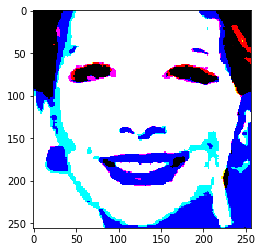

In [28]:
### With preprocess
plt.imshow(X_train_preprocessed[100])

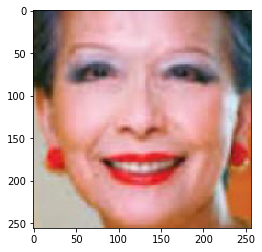

In [29]:
### without preprocess
plt.imshow(X_train_input1[100])

In [30]:
Y_train_age_group = Y_train_input[:, 2]
print(Y_train_age_group)
Y_train_age_group_0 = np.subtract(Y_train_age_group , 1)
print(Y_train_age_group_0)
Y_train_age_group_onehot = to_categorical(Y_train_age_group_0, num_classes= num_classes)
print(Y_train_age_group_onehot.shape)

[11  9 10 ...  8  1  7]
[10  8  9 ...  7  0  6]
(18966, 14)


In [31]:
Y_test_age_group = Y_test_input[:, 2]
print(Y_test_age_group)
Y_test_age_group_0 = np.subtract(Y_test_age_group , 1)
print(Y_test_age_group_0)
Y_test_age_group_onehot = to_categorical(Y_test_age_group_0, num_classes= num_classes)
print(Y_test_age_group_onehot.shape)

[7 5 6 ... 4 7 4]
[6 4 5 ... 3 6 3]
(4742, 14)


In [32]:


### Assign train and test data
X_train = X_train_preprocessed

X_test = X_test_preprocessed

Y_train = Y_train_age_group_onehot

Y_test = Y_test_age_group_onehot

pixel_size = int(X_train.shape[1])

#num_examples = int(X_train_original.shape[0])

print("number of classes are : {}" .format(num_classes))

input_shape = (pixel_size, pixel_size , 3)



number of classes are : 14


In [33]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=True,              ### changed to true
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=True,        ### changed to true
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=10,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.2,
            # set range for random zoom
            zoom_range=0.2,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format='channels_last',
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.2)

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

In [34]:
sum(Y_train[: , 4] == 1)

2200

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(18966, 224, 224, 3)
(224, 224, 3)


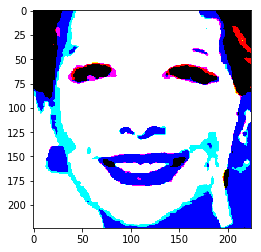

In [35]:
X_train_resize_dummy = []
for i in range(X_train.shape[0]):
    X_train_resize_dummy.append(cv2.resize(X_train[i, :, :, :] , (224, 224)))

X_train_resize = np.array(X_train_resize_dummy)
plt.imshow(X_train_resize[100])
print(X_train_resize.shape)
rec_pap_input_shape = X_train_resize.shape[1:]
print(rec_pap_input_shape)

### data augmentation 

In [36]:
from keras.preprocessing.image import ImageDataGenerator

In [37]:
data_augmentation = True



**Callbacks preparation:**



In [38]:
print(root_path)

In [39]:
# Prepare model model saving directory.
version = 1
model_type = 'softmax%d' % (version)
save_dir = os.path.join(root_path, 'saved_models')
print(save_dir)
model_name = 'softmax_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
callbacks = [checkpoint]

saved_models


# Building Models 

In [41]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
np.random.seed(1000)

## Alexnet

In [42]:
# Prepare model model saving directory.
version = 1
model_type = 'alexnet%d' % (version)
save_dir = os.path.join(root_path, 'saved_models')
print(save_dir)
model_name = 'alexnet_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
callbacks = [checkpoint]

model_name = 'alexnet_sgd_model.{epoch:03d}.h5' 
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
alexnet_checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuaracy',
                             verbose=1,
                             save_best_only=True)
alexnet_callbacks = [alexnet_checkpoint]

saved_models


In [43]:
#Instantiate an empty model
alexnet_model = Sequential()

In [44]:
# 1st Convolutional Layer
alexnet_model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
alexnet_model.add(Activation('relu'))
# Max Pooling
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
alexnet_model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
alexnet_model.add(Activation('relu'))
# Max Pooling
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
alexnet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
alexnet_model.add(Activation('relu'))

# 4th Convolutional Layer
alexnet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
alexnet_model.add(Activation('relu'))

# 5th Convolutional Layer
alexnet_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
alexnet_model.add(Activation('relu'))
# Max Pooling
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
alexnet_model.add(Flatten())
# 1st Fully Connected Layer
alexnet_model.add(Dense(4096, input_shape=(224*224*3,)))
alexnet_model.add(Activation('relu'))
# Add Dropout to prevent overfitting
alexnet_model.add(Dropout(0.4))

# 2nd Fully Connected Layer
alexnet_model.add(Dense(4096))
alexnet_model.add(Activation('relu'))
# Add Dropout
alexnet_model.add(Dropout(0.4))

# 3rd Fully Connected Layer
alexnet_model.add(Dense(1000))
alexnet_model.add(Activation('relu'))
# Add Dropout
alexnet_model.add(Dropout(0.4))

# Output Layer
alexnet_model.add(Dense(14))
alexnet_model.add(Activation('softmax'))

alexnet_model.summary()

# Compile the alexnet_alexnet_model

alexnet_model.compile(loss='categorical_crossentropy',
              optimizer = SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True),
              metrics = ['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
______________________________________

In [45]:
alexnet_model_history = train_func(model = alexnet_model ,x_train = X_train_resize, y_train = Y_train, \
             datagen = datagen ,data_augmentation = False, batch_size = 64, \
             epochs = 25, validation_split =0.2 , \
               root_path = '', save_model = False, model_name= 'alexnet',callbacks = alexnet_callbacks)

Not using data augmentation.

Train on 15172 samples, validate on 3794 samples
Epoch 1/25
 4096/15172 [=======>......................] - ETA: 3:43 - loss: 2.5108 - accuracy: 0.2009

KeyboardInterrupt: 

In [70]:
alexnet_model.save('alexnet.h5')

alexnet_model.save_weights('alexnet_wt.h5')

X_test_resize_dummy = []
for i in range(X_test.shape[0]):
    X_test_resize_dummy.append(cv2.resize(X_test[i, :, :, :] , (224, 224)))

X_test_resize = np.array(X_test_resize_dummy)
plt.imshow(X_test_resize[100])
print(X_test_resize.shape)

4742/4742 [==============================] - 26s 6ms/step
Test loss: 2.31020763804268
Test accuracy: 0.3730493485927582


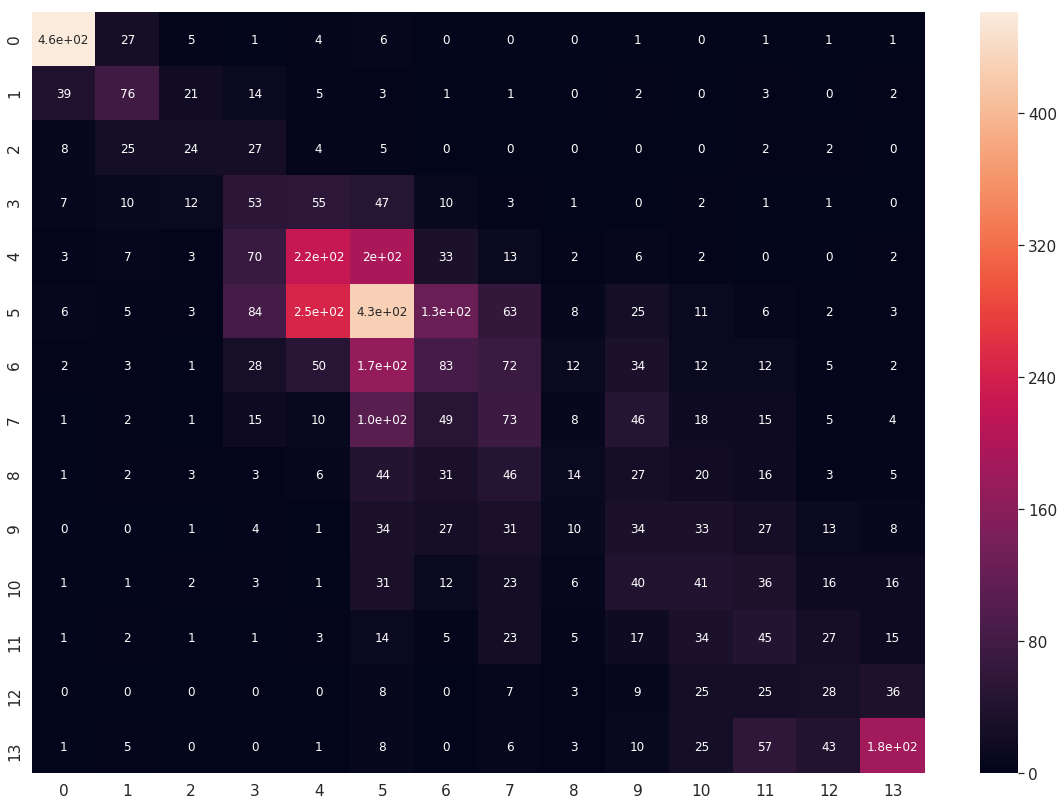

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       508
           1       0.46      0.46      0.46       167
           2       0.31      0.25      0.28        97
           3       0.17      0.26      0.21       202
           4       0.37      0.40      0.38       560
           5       0.39      0.42      0.40      1017
           6       0.22      0.17      0.19       488
           7       0.20      0.21      0.20       352
           8       0.19      0.06      0.10       221
           9       0.14      0.15      0.14       223
          10       0.18      0.18      0.18       229
          11       0.18      0.23      0.21       193
          12       0.19      0.20      0.20       141
          13       0.66      0.54      0.59       344

    accuracy                           0.37      4742
   macro avg       0.32      0.32      0.32      4742
weighted avg       0.37      0.37      0.37      4742



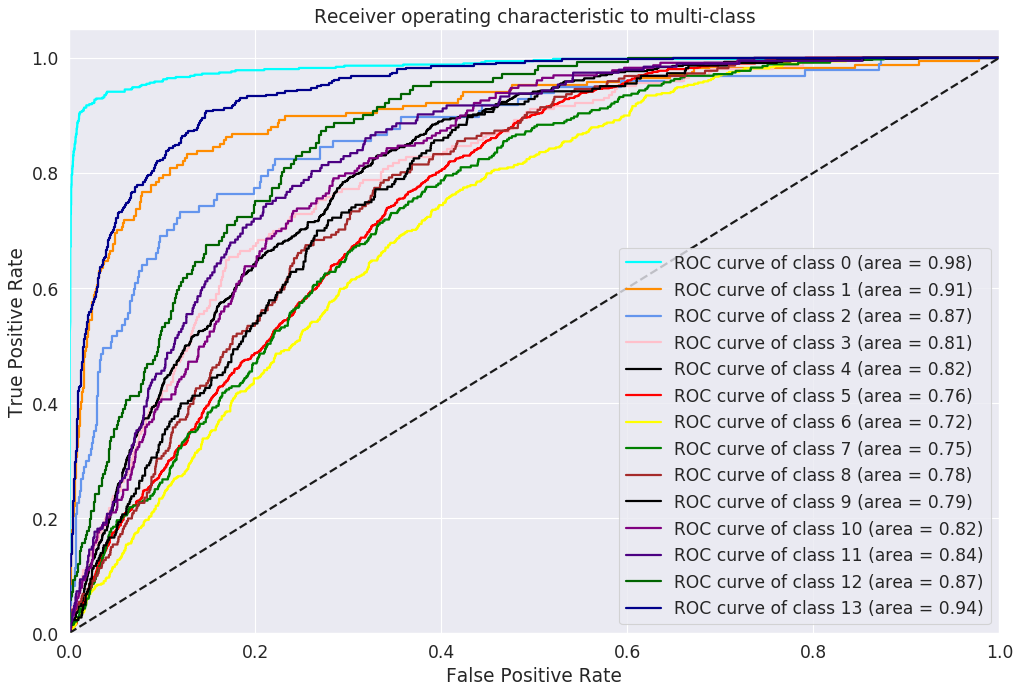

In [88]:
metrics(alexnet_model,1)

## lenet 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(18966, 32, 32, 3)


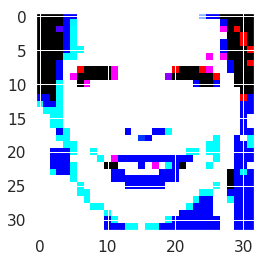

In [166]:
X_train_resize_dummy = []
for i in range(X_train.shape[0]):
    X_train_resize_dummy.append(cv2.resize(X_train[i, :, :, :] , (32, 32)))

X_train_resize = np.array(X_train_resize_dummy)
plt.imshow(X_train_resize[100])
print(X_train_resize.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4742, 32, 32, 3)


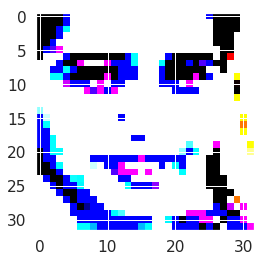

In [168]:
X_test_resize_dummy = []
for i in range(X_test.shape[0]):
    X_test_resize_dummy.append(cv2.resize(X_test[i, :, :, :] , (32, 32)))

X_test_resize = np.array(X_test_resize_dummy)
plt.imshow(X_test_resize[100])
print(X_test_resize.shape)

In [169]:
version = 1
model_type = 'lenet%d' % (version)
save_dir = os.path.join(root_path, 'saved_models')
print(save_dir)
model_name = 'lenet_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
callbacks = [checkpoint]

model_name = 'lenet_sgd_model.{epoch:03d}.h5' 
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
lenet_checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuaracy',
                             verbose=1,
                             save_best_only=True)
lenet_callbacks = [lenet_checkpoint]

saved_models


In [182]:
lenet_model = Sequential()

lenet_model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
lenet_model.add(layers.AveragePooling2D())

lenet_model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
lenet_model.add(layers.AveragePooling2D())

lenet_model.add(layers.Flatten())

lenet_model.add(layers.Dense(units=120, activation='relu'))

lenet_model.add(layers.Dense(units=84, activation='relu'))

lenet_model.add(layers.Dense(units=14, activation = 'softmax'))

In [183]:
lenet_model.compile(loss='categorical_crossentropy',
              optimizer = SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True),
              metrics = ['accuracy'])

In [184]:
lenet_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 120)               69240     
_________________________________________________________________
dense_35 (Dense)             (None, 84)              

In [185]:
lenet_model_history = train_func(model = lenet_model ,x_train = X_train_resize, y_train = Y_train, \
             datagen = datagen ,data_augmentation = False, batch_size = 64, \
             epochs = 25, validation_split =0.2 , \
               root_path = '', save_model = False, model_name= 'lenet',callbacks = lenet_callbacks)

Not using data augmentation.
Train on 15172 samples, validate on 3794 samples
Epoch 1/25
15172/15172 [==============================] - 2s 148us/step - loss: 2.5841 - accuracy: 0.2473 - val_loss: 2.3059 - val_accuracy: 0.2646
Epoch 2/25
 1408/15172 [=>............................] - ETA: 1s - loss: 2.1930 - accuracy: 0.3033

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuaracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


15172/15172 [==============================] - 2s 133us/step - loss: 2.1498 - accuracy: 0.2955 - val_loss: 2.1292 - val_accuracy: 0.2957
Epoch 3/25
15172/15172 [==============================] - 2s 133us/step - loss: 2.0511 - accuracy: 0.3158 - val_loss: 2.0646 - val_accuracy: 0.3097
Epoch 4/25
15172/15172 [==============================] - 2s 133us/step - loss: 1.9778 - accuracy: 0.3311 - val_loss: 2.1521 - val_accuracy: 0.3121
Epoch 5/25
15172/15172 [==============================] - 2s 118us/step - loss: 1.9279 - accuracy: 0.3415 - val_loss: 3.0060 - val_accuracy: 0.2298
Epoch 6/25
15172/15172 [==============================] - 2s 119us/step - loss: 1.9488 - accuracy: 0.3349 - val_loss: 1.9820 - val_accuracy: 0.3189
Epoch 7/25
15172/15172 [==============================] - 2s 119us/step - loss: 1.8409 - accuracy: 0.3613 - val_loss: 1.9129 - val_accuracy: 0.3371
Epoch 8/25
15172/15172 [==============================] - 2s 120us/step - loss: 1.7999 - accuracy: 0.3699 - val_loss: 1.898

In [189]:
lenet_model.save('lenet.h5')

lenet_model.save_weights('lenet_wt.h5')

4742/4742 [==============================] - 0s 76us/step
Test loss: 2.0197516405245564
Test accuracy: 0.32138338685035706


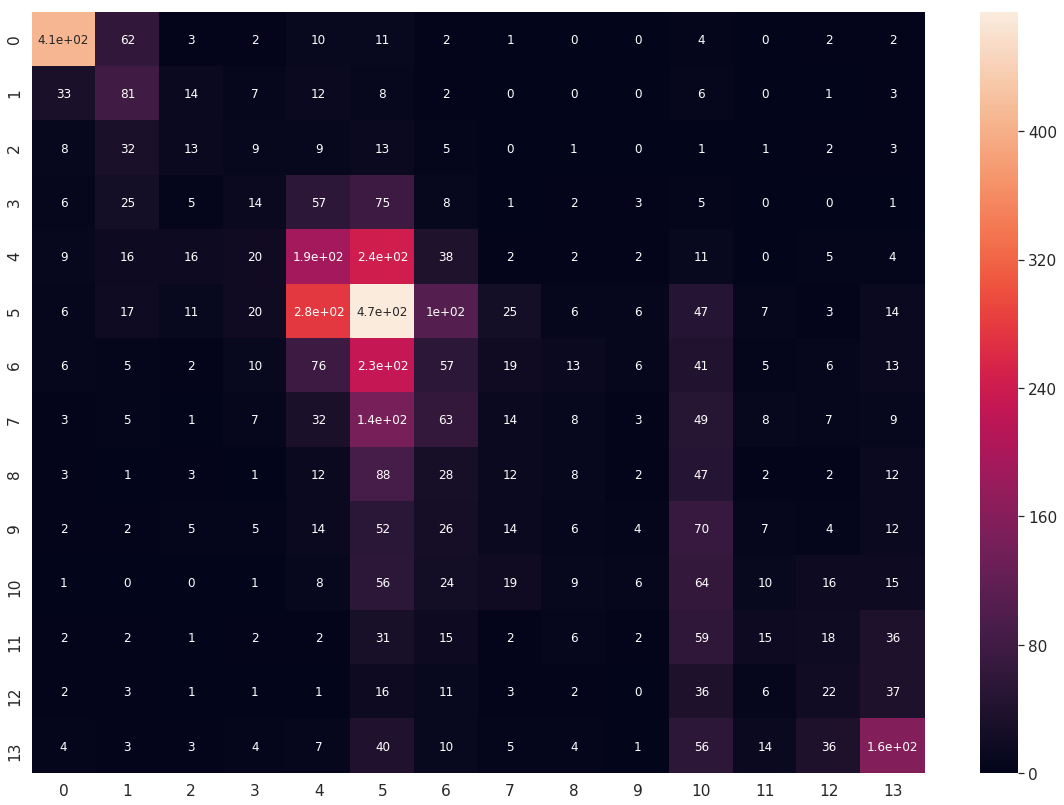

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       508
           1       0.32      0.49      0.38       167
           2       0.17      0.13      0.15        97
           3       0.14      0.07      0.09       202
           4       0.27      0.34      0.30       560
           5       0.32      0.47      0.38      1017
           6       0.15      0.12      0.13       488
           7       0.12      0.04      0.06       352
           8       0.12      0.04      0.06       221
           9       0.11      0.02      0.03       223
          10       0.13      0.28      0.18       229
          11       0.20      0.08      0.11       193
          12       0.18      0.16      0.17       141
          13       0.49      0.46      0.47       344

    accuracy                           0.32      4742
   macro avg       0.25      0.25      0.24      4742
weighted avg       0.30      0.32      0.30      4742



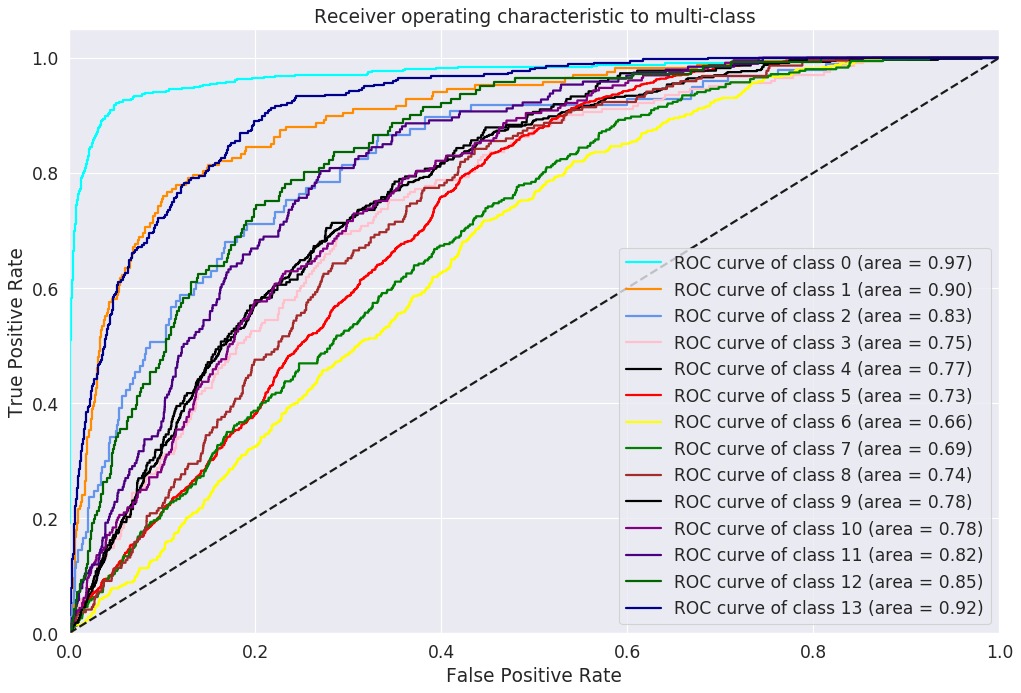

In [190]:
metrics(lenet_model,1)